![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)


## Sentiment analysis of IMDB reviews - LogRes versus NN

## 1. First block - Let's load the reviews to apply Bag of Words

We will need pandas and sklearn's CountVectorizer to apply bag of words on top of the phrases.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np
import time
import datetime

To load data from the file imdb_labelled.txt and show its first value

In [2]:
df = pd.read_csv('imdb_labelled.txt', names=['sentence','label'], sep='\t')
print(df.iloc[0])

sentence    A very, very, very slow-moving, aimless movie ...
label                                                       0
Name: 0, dtype: object


A quite negative assessment ... as you can see the label 0 is "negative", so 1 will be "positive" (analyzing the sentiment of the phrase)

Let's prepare the data, to have a test and a train

In [3]:
sentences = df['sentence'].values
y = df['label'].values

In [4]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

Now comes the time to create our bag of words, for that we will use the CountVectorizer from sklearn, which we will train with the words / phrases of the train and then we will apply to each set of phrases train and test

In [5]:
vectorizador = CountVectorizer()
vectorizador.fit(sentences_train)

x_train = vectorizador.transform(sentences_train)
x_test = vectorizador.transform(sentences_test)

x_train

<561x2505 sparse matrix of type '<class 'numpy.int64'>'
	with 8413 stored elements in Compressed Sparse Row format>

In [6]:
print(x_train[0,:])

  (0, 360)	1
  (0, 532)	1
  (0, 1532)	1
  (0, 2471)	1


## 2. First block - Regression Logistics with Bag Of Words

To start, let's load those libraries that we need

### 2.1 We load the libraries for the Logistic Regression and train it with cross validation looking for the best C parameter of the logistic regression

In [9]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(x_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)


Best cross-validation score: 0.74
Best parameters:  {'C': 1}
Best estimator:  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [10]:
lr = grid.best_estimator_
lr.fit(x_train, y_train)
lr.predict(x_test)

score_test = lr.score(x_test, y_test)

print('Accuracy for IMDB data in test data: {:.4f}'.format(score_test))


Accuracy for IMDB data in test data: 0.7487


## 3.Second block - Let's go for a neural network

A simple network, for now no RNN

Let's go for the libraries we need

In [11]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt

Let's see how many dimensions I have for the input of the first layer of the neural network

In [12]:
input_dim = x_train.shape[1]
print('Number dimensions:', input_dim)

Number dimensions: 2505


Let's define the neural network

In [13]:
model = ks.Sequential()
model.add(ks.layers.Dense(512, input_dim=input_dim, activation='relu'))
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(256, activation='relu'))
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(50, activation='relu'))
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(1, activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1283072   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                12850     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

In [16]:

model.compile(loss='binary_crossentropy', \
              optimizer='adam', \
               metrics=['accuracy'])

Training the model

In [17]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=96)

Epoch 1/10
6/6 [==============================] - 1s 109ms/step - loss: 0.6969 - accuracy: 0.5046 - val_loss: 0.7185 - val_accuracy: 0.4866
Epoch 2/10
6/6 [==============================] - 0s 13ms/step - loss: 0.6912 - accuracy: 0.5423 - val_loss: 0.6913 - val_accuracy: 0.6310
Epoch 3/10
6/6 [==============================] - 0s 12ms/step - loss: 0.6644 - accuracy: 0.5873 - val_loss: 0.6738 - val_accuracy: 0.6578
Epoch 4/10
6/6 [==============================] - 0s 13ms/step - loss: 0.6415 - accuracy: 0.6523 - val_loss: 0.6637 - val_accuracy: 0.6845
Epoch 5/10
6/6 [==============================] - 0s 12ms/step - loss: 0.5989 - accuracy: 0.7407 - val_loss: 0.6525 - val_accuracy: 0.6952
Epoch 6/10
6/6 [==============================] - 0s 12ms/step - loss: 0.5421 - accuracy: 0.8210 - val_loss: 0.6080 - val_accuracy: 0.7433
Epoch 7/10
6/6 [==============================] - 0s 12ms/step - loss: 0.4264 - accuracy: 0.8638 - val_loss: 0.5515 - val_accuracy: 0.7487
Epoch 8/10
6/6 [==========

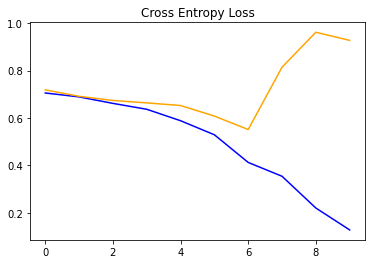

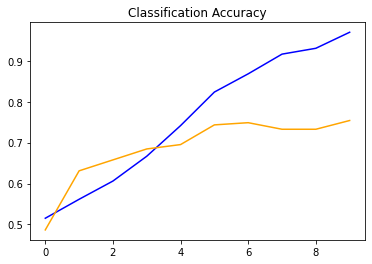

In [18]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

We can see that the neural network sucks quite a bit, plus it easily goes into overfitting ... so logistic regression, with less effort, works just as badly.

In [19]:
_,score_test = model.evaluate(x_test, y_test)

print('Accuracy for IMDB data in test data with NN: {:.4f}'.format(score_test))

6/6 [==============================] - 0s 2ms/step - loss: 0.9269 - accuracy: 0.7540
Accuracy for IMDB data in test data with NN: 0.7540
